# Multivariate regression for attention: exploring attrition

In this notebook, we shall conduct regression analysis to look at the effect of different variables on the attrition. But our main goal is to understand attention and to explore attention threshold. 

Note: This is after rematching i.e. when we decided to re-run the entire analysis properly defining the filtered sample. 

**Outcome Variable:**

Attrition rate

**Independent Variables:**

1. Gender
2. Scientist’s (binned) academic age at the time of retraction
3. Number of (binned) citations prior to retraction
4. Number of (binned) collaborators prior to retraction
5. Number of (binned) papers published up to retraction
6. (Aggregated) Field
7. Author contribution rank in the paper i.e. first or last or middle
8. Retraction year
9. Retraction reason
10. Retracted paper published in journal or conference
11. Journal impact factor (or rank)
12. Affiliation rank at the time of retraction
13. Number of authors in the retracted paper
14. **Attention given to the paper i.e. number of mentions within the 12 month retraction window. This will be computed and added in multiple mutually exclusive ways:**
    1. **(Tertiarized/Binarized) Altmetric score**
    2. **(Tertiarized/Binarized) mentions from four types of sources all entered separately into the regression model.**
    3. **Optionally (Tertiarized/Binarized) mentions from 14 different sources all entered separately into the regression model.**

In [1]:
# Importing relevant libraries

import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import math
import numpy as np

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [12]:
# Reading the regression file

#df_main = pd.read_csv("/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_effects_on_collaboration_networks/data/h4_altmetric/regression/RW_Authors_forRegression_rematching.csv")
#df_main = pd.read_csv("/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_openalex/retraction_effects_on_academic_careers/data/processed/RW_authors_w_confounders_filteredSample_postNHB.csv")

df_main=pd.read_csv('test_gap_95percent.csv')
df_main = df_main[df_main['nRetracted'] == 1]
# Let us define the dependent variable

Yi = 'AttritedClass'
Yroot = 'attritionClusteredLinearwSJR'


df_main.MAGAID.nunique()

FileNotFoundError: [Errno 2] No such file or directory: 'test_gap_95percent.csv'

# DANGER AREA

Here I am trying to give old attrited class to the new data just to see how it performs


In [8]:
danger=False
danger2 = False

def get_oldattritionclass(row):
    if row['YearsActive'] in [0,-1]:
        return 1
    elif row['YearsActive'] > 0:
        return 0
    else:
        return -1

if(danger):
    print("in danger 1")
    df_pubhistories = pd.read_csv("../../data/processed/Retracted_Authors_PubHistories.csv",
                                 usecols=['MAGAID','RetractionYear','MAGPubYear'])\
                            .drop_duplicates()
    
    df_pubhistories = df_pubhistories.groupby(['MAGAID','RetractionYear'])['MAGPubYear'].max().reset_index()
    df_pubhistories['YearsActive'] = df_pubhistories['MAGPubYear']-df_pubhistories['RetractionYear']
    df_pubhistories['AttritedClass'] = df_pubhistories.apply(lambda row: get_oldattritionclass(row), 
                                                             axis=1)
    df_pubhistories = df_pubhistories.drop(columns=['MAGPubYear','RetractionYear','YearsActive'])
    df_main = df_main.drop(columns=['AttritedClass'])
    df_main = df_main.merge(df_pubhistories, on='MAGAID')
    

if(danger2):
    
    df_pubhistories = pd.read_csv("../../data/processed/Retracted_Authors_PubHistories.csv",
                                 usecols=['MAGAID','RetractionYear','MAGPubYear', 'MAGPID'])\
                            .drop_duplicates()
    
    df_retraction_notices = pd.read_csv("../../data/processed/retraction_notices_postfiltering.csv")
    
    df_pubhistories = df_pubhistories[~df_pubhistories['MAGPID'].isin(df_retraction_notices['PID'])]
    
    df_pubhistories = df_pubhistories.drop(columns=['MAGPID'])
    
    # Function to check if any publication is within 5 years of retraction
    def check_retraction(group):
        # Logic for not-attrited
        if any((group['MAGPubYear'] > group['RetractionYear']) & (group['MAGPubYear'] <= group['RetractionYear'] + 5)):
            # We will return AttritedClass status, and activity or no activity flag and year to plot
            valid_years = group[group['MAGPubYear'] > group['RetractionYear']]['MAGPubYear']
            returnval = [0, "yes activity", valid_years.min()]
            return pd.Series(returnval, index=['AttritedClass','ActivityOrNo', 'YearToPlot'])
        
        # Logic for attrited
        elif any(group['MAGPubYear'] > group['RetractionYear'] + 5):
            valid_years = group[group['MAGPubYear'] > group['RetractionYear']]['MAGPubYear']
            returnval =[1, "yes activity", valid_years.min()]
            return pd.Series(returnval, index=['AttritedClass','ActivityOrNo', 'YearToPlot'])
        
        elif max(group['MAGPubYear'] == max(group['RetractionYear'])) or \
            max(group['MAGPubYear'] == max(group['RetractionYear'])-1):
            returnval = [1, "no activity", group['MAGPubYear'].max()]
            return pd.Series(returnval, index=['AttritedClass','ActivityOrNo', 'YearToPlot'])
        
        # Logic for not considered
        else:
            returnval = [-1, "no activity", group['MAGPubYear'].max()]
            return pd.Series(returnval, index=['AttritedClass','ActivityOrNo', 'YearToPlot'])
    
    # Group by MAGAID and apply the function
    df_attritedClass = df_pubhistories\
                .groupby('MAGAID').apply(check_retraction)
    
    df_main = df_main.drop(columns=['AttritedClass'])
    df_main = df_main.merge(df_attritedClass, on='MAGAID')


In [3]:
# Removing class that's neither attrited nor non-attrited (i.e. those that are attrited due to something else)
df_main = df_main[df_main.AttritedClass.isin([0,1])]

df_main.MAGAID.nunique()

10362

In [4]:
# Checking how many attrited and how many not attrited
df_main[['MAGAID','AttritedClass']].drop_duplicates().AttritedClass.value_counts()

# Old Kinga's logic --> New better logic
# 0    10024 --> 11653
# 1     2758 --> 3311

AttritedClass
0    8606
1    1756
Name: count, dtype: int64

## Removing Outliers

In [5]:
remove_outliers = False
# Let us remove those with really high citations, collaborators and papers
if(remove_outliers):
    papers_99th = df_main['MAGCumPapersAtRetraction'].quantile(.99)
    cites_99th = df_main['MAGCumCitationsAtRetraction'].quantile(.99)
    collabs_99th = df_main['MAGCumCollaboratorsAtRetraction'].quantile(.99)

    df_main = df_main[df_main['MAGCumPapersAtRetraction'].le(papers_99th) & 
                     df_main['MAGCumCitationsAtRetraction'].le(cites_99th) & 
                     df_main['MAGCumCollaboratorsAtRetraction'].le(collabs_99th)]

In [6]:
df_main[['MAGAID','AttritedClass']].drop_duplicates().AttritedClass.value_counts()

AttritedClass
0    8606
1    1756
Name: count, dtype: int64

In [7]:
# Defining attention columns

attention_agg_cols = ['AltmetricScoreAtRetraction',
                     'AggregateSocialMediaMentionsAtRetraction',
                     'AggregateNewsMediaMentionsAtRetraction',
                     'AggregateBlogsMentionsAtRetraction',
                     'AggregateKnowledgeRepositoriesMentionsAtRetraction']

# Creating the relevant dataframe
df = df_main[['Record ID','MAGAID'] + [Yi,'AttritedClassRobust']+
                 ['GenderizeGender',
                 'AcademicAgeAtRetraction',
                 'MAGCumPapersAtRetraction',
                 'LogMAGCumCitationsAtRetraction',
                 'LogMAGCumCollaboratorsAtRetraction']+
                list(df_main.\
                    filter(regex=("Field_.*")).columns)+
                ['MAGAIDRankTypeInRetractedPaper',
                'RetractionYear',
                'ReasonPropagatedMajorityOfMajority',
                'MAGJournalType',
                'SJRQuartileRetractedPaperYear',
                'MAGRetractionYearAffRankOrdinal',
                'NumAuthorsInRetractedPaper']+
                attention_agg_cols].drop_duplicates()

In [8]:
df.GenderizeGender.value_counts()

GenderizeGender
male      7649
female    2713
Name: count, dtype: int64

In [9]:
df.MAGCumPapersAtRetraction.describe()

count    10362.000000
mean        57.040147
std        103.399980
min          1.000000
25%          5.000000
50%         19.000000
75%         63.000000
max       1518.000000
Name: MAGCumPapersAtRetraction, dtype: float64

In [10]:
df['ReasonPropagatedMajorityOfMajority'].value_counts()

ReasonPropagatedMajorityOfMajority
plagiarism    2899
mistake       2825
other         2460
misconduct    2178
Name: count, dtype: int64

In [11]:
df.columns

Index(['Record ID', 'MAGAID', 'AttritedClass', 'AttritedClassRobust',
       'GenderizeGender', 'AcademicAgeAtRetraction',
       'MAGCumPapersAtRetraction', 'LogMAGCumCitationsAtRetraction',
       'LogMAGCumCollaboratorsAtRetraction', 'Field_art', 'Field_biology',
       'Field_business', 'Field_chemistry', 'Field_computerscience',
       'Field_economics', 'Field_engineering', 'Field_environmentalscience',
       'Field_geography', 'Field_geology', 'Field_history',
       'Field_materialsscience', 'Field_mathematics', 'Field_medicine',
       'Field_philosophy', 'Field_physics', 'Field_politicalscience',
       'Field_psychology', 'Field_sociology', 'MAGAIDRankTypeInRetractedPaper',
       'RetractionYear', 'ReasonPropagatedMajorityOfMajority',
       'MAGJournalType', 'SJRQuartileRetractedPaperYear',
       'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper',
       'AltmetricScoreAtRetraction',
       'AggregateSocialMediaMentionsAtRetraction',
       'AggregateNewsMed

In [12]:
df.shape

(10362, 40)

## Running Multivariate Regressions

In [13]:
def regress(df, equation):
    df = df.dropna()
    return smf.ols(Yi + "~ "+equation, data=df, missing='drop').fit(cov_type='cluster',
                                                                      cov_kwds={'groups':df['Record ID']})


In [14]:
# Defining dictionary that goes from field id to expression

expression_dict = {
        "age": "AcademicAgeAtRetraction",
        "gender": "C(GenderizeGender, Treatment(reference='male'))",
        "yearofretraction": "RetractionYear",
        "logcitations":"LogMAGCumCitationsAtRetraction",
        "logcollaborators":"LogMAGCumCollaboratorsAtRetraction",
        "papers":"MAGCumPapersAtRetraction",
        "reasons":"C(ReasonPropagatedMajorityOfMajority, Treatment(reference='mistake'))",
        "affrank":"MAGRetractionYearAffRankOrdinal",
        "contributionrank":"C(MAGAIDRankTypeInRetractedPaper, Treatment(reference='First or Last or Only Author'))",
        "numauthors":"NumAuthorsInRetractedPaper",
        "venue":"C(MAGJournalType, Treatment(reference='conference'))",
        "impactfactor":"SJRQuartileRetractedPaperYear",
        "field": " + ".join(list(df_main.filter(regex=("Field_.*")).columns))
}


fieldid_to_fieldname = {
        "age": ["AcademicAgeAtRetraction"],
        "gender": ["GenderizeGender"],
        "yearofretraction": ["RetractionYear"],
        "logcitations":["LogMAGCumCitationsAtRetraction"],
        "logcollaborators":["LogMAGCumCollaboratorsAtRetraction"],
        "papers":["MAGCumPapersAtRetraction"],
        "reasons":["ReasonPropagatedMajorityOfMajority"],
        "affrank":["MAGRetractionYearAffRankOrdinal"],
        "contributionrank":["MAGAIDRankTypeInRetractedPaper"],
        "numauthors":["NumAuthorsInRetractedPaper"],
        "venue":["MAGJournalType"],
        "impactfactor":["SJRQuartileRetractedPaperYear"],
        "field": list(df_main.filter(regex=("Field_.*")).columns)
}

In [15]:
df_main[df_main['SJRQuartileRetractedPaperYear'].isna()]

MAGAID     MAGAuthorName  Record ID      MAGPID  RetractionYear  \
0      2127983451  william r jacobs       2343  1790891469          1997.0   
1      2127983451  william r jacobs       2343  1790891469          1997.0   
2      2127983451  william r jacobs       2343  1790891469          1997.0   
3      2127983451  william r jacobs       2343  1790891469          1997.0   
4      2127983451  william r jacobs       2343  1790891469          1997.0   
...           ...               ...        ...         ...             ...   
24927  2228321979        s binraman      13510  1480448851          2010.0   
24936  2386046131       chen leduan       4455  2354229457          2010.0   
24938  2632201486          m mowlem      18702  2059028859          2011.0   
24939  2643719218          h morgan      18702  2059028859          2011.0   
24940   268272321  alex mishelevitz      16929  1970421558          2012.0   

       nRetracted  dateobject           JID          CSID  \
0               1  1994-07-01  1.332748e+08           NaN   
1               1  1994-07-01  1.332748e+08           NaN   
2               1  1994-07-01  1.332748e+08           NaN   
3               1  1994-07-01  1.332748e+08           NaN   
4               1  1994-07-01  1.332748e+08           NaN   
...           ...         ...           ...           ...   
24927           1  2010-11-29           NaN  2.755844e+09   
24936           1  2010-01-01  2.764954e+09           NaN   
24938           1  2011-08-01  5.404304e+07           NaN   
24939           1  2011-08-01  5.404304e+07           NaN   
24940           1  2012-10-01  1.120950e+08           NaN   

                                             JournalName  ...  \
0                                journal of bacteriology  ...   
1                                journal of bacteriology  ...   
2                                journal of bacteriology  ...   
3                                journal of bacteriology  ...   
4                                journal of bacteriology  ...   
...                                                  ...  ...   
24927                                                NaN  ...   
24936                    journal of guangzhou university  ...   
24938  microsystem technologies micro and nanosystems...  ...   
24939  microsystem technologies micro and nanosystems...  ...   
24940     journal of chemical technology & biotechnology  ...   

      AltmetricScorePreRetraction AltmetricScorePostRetraction  \
0                             3.0                          6.0   
1                             3.0                          6.0   
2                             3.0                          6.0   
3                             3.0                          6.0   
4                             3.0                          6.0   
...                           ...                          ...   
24927                         0.0                          0.0   
24936                         0.0                          0.0   
24938                         0.0                          0.0   
24939                         0.0                          0.0   
24940                         0.0                          0.0   

       YearOfAttrition OriginalPaperDate_x  OriginalPaperDate_y  YearsActive  \
0                 -1.0                 NaN                  NaN          NaN   
1                 -1.0                 NaN                  NaN          NaN   
2                 -1.0                 NaN                  NaN          NaN   
3                 -1.0                 NaN                  NaN          NaN   
4                 -1.0                 NaN                  NaN          NaN   
...                ...                 ...                  ...          ...   
24927           2010.0          2010-11-02           2010-11-02          0.0   
24936           2009.0          2009-11-18           2009-11-18         -1.0   
24938           2011.0          2011-02-17     

In [16]:
# Academic Age
def age():
    global equation, ests, data
    field_id = "age"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Year of retraction
def yearofretraction():
    global equation, ests, data
    field_id = "yearofretraction"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of citations
def logcitations():
    global equation, ests, data
    field_id = "logcitations"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of collaborators
def logcollaborators():
    global equation, ests, data
    field_id = "logcollaborators"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of papers
def papers():
    global equation, ests, data
    field_id = "papers"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Gender
def gender():
    global equation, ests, data
    field_id = "gender"
    equation = equation + " + " + expression_dict.get(field_id)
    # Cleaning gender
    data = data[data.GenderizeGender.isin(['male','female'])]
    est = regress(data, equation)
    ests.append(est)

# Reason of retraction
def reasons():
    global equation, ests, data
    field_id = "reasons"
    equation = equation + " + " + expression_dict.get(field_id)
    # Cleaning reasons
    #data = data[data.ReasonPropagatedMajorityOfMajority.isin(['M','P','H'])]
    est = regress(data, equation)
    ests.append(est)

# Author affiliation rank 
def affrank():
    global equation, ests, data
    field_id = "affrank"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Author contribution rank
def contributionrank():
    global equation, ests, data
    field_id = "contributionrank"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of authors in the paper
def numauthors():
    global equation, ests, data
    field_id = "numauthors"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Journal or conference
def venue():
    global equation, ests, data
    field_id = "venue"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Field
def field():
    global equation, ests, data
    field_id = "field"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)
    
def regress_one_by_one(attention_expression, funcs):
    """
    In this function, we shall look at the effect of 
    attention on attrition while controlling for other 
    variables. We shall, however, add the controls one by one.
    """
    global equation, ests, data
    
    # We will save out estimators in a list
    ests = []
    
    # Initializing data
    data = df.copy()
    
    # Attention is our key variable, so we fix that
    
    equation = attention_expression
    
    est = regress(data, equation)
    
    ests.append(est)
    
    for func in funcs:
        func()
    
    return ests

def regress_all_together(dfi, attention_field, attention_expression, field_ids):
    """
    In this function, we shall run one regression with all the 
    controls given as func_ids
    """
    
    # Initializing the equation
    equation = attention_expression
    
    for field_id in field_ids:
        equation = equation + " + " + expression_dict.get(field_id)
        
    data = dfi.copy()
    
    # Fields to keep
    fields_to_keep = []
    for fid in field_ids:
        fields_to_keep += fieldid_to_fieldname.get(fid)
    
    print("Fields we keep for this regresion",fields_to_keep)
    
    data = data[['MAGAID','Record ID', attention_field, Yi]+fields_to_keep].drop_duplicates()
    
    # Cleaning if needed
#     if "gender" in field_ids:
#         # Cleaning gender
#         data = data[data.GenderizeGender.isin(['male','female'])]

#     if "reasons" in field_ids:
#         data = data[data.ReasonPropagatedMajorityOfMajority.isin(['M','P','H'])]
        
    est = regress(data, equation)
    
    return est

### Regression with discretized scores

In [17]:
def discretize_attention_binary(score, threshold_high=5):
    if score < threshold_high:
        return "low attention"
    elif score >= threshold_high:
        return "high attention"
        
def discretize_attention_tertiary(score, threshold_medium=3, threshold_high=5):
    assert(threshold_medium < threshold_high)
    if score < threshold_medium:
        return "low attention"
    elif score >= threshold_medium and score < threshold_high:
        return "medium attention"
    elif score >= threshold_high:
        return "high attention"

#### Defining default and alternating fields

In [18]:
default_fids = ["yearofretraction", "gender", "contributionrank", "venue", "impactfactor",
             "reasons", "field", "affrank", "numauthors",]

alternating_fids = ["age", "papers", "logcitations", "logcollaborators"]

funcOrder = [age, yearofretraction, gender, contributionrank, venue, 
             reasons, field, logcitations, logcollaborators, papers, 
             affrank, numauthors,]

### Finding optimal threshold for discretizing attention

#### Understanding numerical bounds

Let us first see the limit i.e. upper bound we need to explore for each type of mention.

In [19]:
# Upper bound for Altmetric Score 
ub_altmetric = int(df['AltmetricScoreAtRetraction'].quantile(.99))
ub_altmetric

65

<AxesSubplot:>

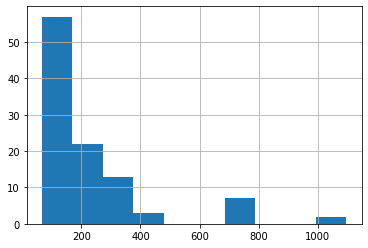

In [20]:
df[df['AltmetricScoreAtRetraction'].gt(ub_altmetric)].AltmetricScoreAtRetraction.hist()

In [21]:
df[df['AltmetricScoreAtRetraction'].gt(ub_altmetric)].AltmetricScoreAtRetraction.\
    value_counts().reset_index().sort_values(by='AltmetricScoreAtRetraction')


AltmetricScoreAtRetraction  count
13                       67.00      3
23                       73.00      1
21                       88.75      1
14                       92.25      2
10                       93.25      3
15                       96.75      2
8                        97.00      5
0                       101.25     13
6                       105.25      6
18                      117.50      2
2                       124.25      9
17                      126.00      2
5                       133.50      6
26                      145.00      1
25                      158.25      1
11                      170.75      3
22                      175.00      1
3                       185.00      7
19                      191.75      1
9                       195.75      4
24                      197.25      1
7                       212.25      5
20                      294.75      1
1                       333.25     12
12                      454.50      3
4                       767.00      7
16                     1097.00      2

In [22]:
def explore_thresholds_binary_helper(dfi, experience_fields, attention_field, ub):
    
    print("Exploring following experience fields:", experience_fields)
        
    # This is the dictionary we shall add return threshold --> [coeff, pvalue]

    threshold_to_coefs = {}
    regressors = []
    
    # Going through each threshold
    for threshold_high in range(1,ub+1):
        
        print("Threshold high:",threshold_high)
        
        # Discretizing the current attention field into binary based on the current threshold
        dfi['Binary'+attention_field] = dfi.apply(lambda row: \
                                        discretize_attention_binary(row[attention_field],threshold_high),
                                        axis=1)
        
        # Describing the attention expression
        attention_exp = "C(Binary"+attention_field+", Treatment('low attention'))"
        
        # Finally regressing
        est = regress_all_together(dfi, 'Binary'+attention_field, attention_exp, default_fids + experience_fields)
        
        # Saving the regression coefficients for attention 
        threshold_to_coefs[threshold_high] = [est.params[attention_exp+'[T.high attention]'],
                                              est.pvalues[attention_exp+'[T.high attention]']]
        
        # Saving the regressor
        regressors.append(est)
        
    return threshold_to_coefs, regressors

In [23]:
def explore_thresholds_binary(attention_field, ub):
    
    # We will run this function for all the different kinds of experience fields together and one by one
    
    # Copying the df locally
    dfi = df.copy()
    
    # The dictionary we shall populate for each variant of model
    exp_field_to_threshold_dicts = {}
    
    # Going through each experience field
    for alt_fid in alternating_fids:
        
        experience_fields = [alt_fid]
        
        threshold_to_coefs, regressors = explore_thresholds_binary_helper(dfi, experience_fields, attention_field, ub)
        
        exp_field_to_threshold_dicts[alt_fid] = threshold_to_coefs
        
    return exp_field_to_threshold_dicts, regressors

In [24]:
def explore_threshold_tertiary_helper(dfi, experience_fields, attention_field, ub,
                                     reference_category="medium attention"):
    
    print("Exploring field:", experience_fields)
    
    threshold_to_coefs = {}
    
    ests = []
    
    middle_high = [(a, b) for a in range(1,ub) for b in range(ub) if a < b]
    
    # Going through each pair of middle and high attention threshold
    for medium,high in middle_high:
        
        print("Threshold medium:",medium,", high:",high)
        
        # Discretizing attention
        dfi['Tertiary'+attention_field] = dfi.apply(lambda row: \
                                        discretize_attention_tertiary(row[attention_field],medium,high),
                                        axis=1)
        
        # We use try due to sparsity as thresholds increase (due to skewness of attention distribution)
        
        try:
            attention_exp = "C(Tertiary"+attention_field+", Treatment('"+reference_category+"'))"

            est = regress_all_together(dfi, 'Tertiary'+attention_field, attention_exp, default_fids + experience_fields)
            #ests.append(est)
            
            if(reference_category == "medium attention"):
            
                threshold_to_coefs[(medium,high)] = [(est.params[attention_exp+'[T.low attention]'],
                                                      est.pvalues[attention_exp+'[T.low attention]']),
                                                    (est.params[attention_exp+'[T.high attention]'],
                                                      est.pvalues[attention_exp+'[T.high attention]'])]
                
            elif(reference_category == "low attention"):
                
                threshold_to_coefs[(medium,high)] = [(est.params[attention_exp+'[T.medium attention]'],
                                                      est.pvalues[attention_exp+'[T.medium attention]']),
                                                    (est.params[attention_exp+'[T.high attention]'],
                                                      est.pvalues[attention_exp+'[T.high attention]'])]
                
        except:
            print("##################")
            print("Can't process", medium, high)
            print("##################")

    return threshold_to_coefs

In [25]:
def explore_thresholds_tertiary(attention_field, ub, reference_category="medium attention"):
    
    # We will run this function for all the different kinds of experience fields together and one by one
    
    dfi = df.copy()
    
    exp_field_to_threshold_dicts = {}
    
    for alt_fid in alternating_fids:
        
        experience_fields = [alt_fid]
        
        threshold_to_coefs = explore_threshold_tertiary_helper(dfi, experience_fields, attention_field, ub,
                                                              reference_category)
        
        exp_field_to_threshold_dicts[alt_fid] = threshold_to_coefs
            
    return exp_field_to_threshold_dicts

#### Finding threshold for altmetric score

In [26]:
dict_binary_altmetric, regressors_altmetric = explore_thresholds_binary("AltmetricScoreAtRetraction", ub_altmetric)

Exploring following experience fields: ['age']
Threshold high: 1
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold high: 2
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Fiel

Threshold high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field

Threshold high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field

Threshold high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field

Threshold high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field

Threshold high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field

Threshold high: 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_

Threshold high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Fiel

Threshold high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Fiel

Threshold high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Fiel

Threshold high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Fiel

Threshold high: 3
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold high: 4
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', '

Threshold high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience',

Threshold high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience',

Threshold high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience',

Threshold high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience',

Threshold high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience',

Threshold high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscien

Threshold high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscien

Threshold high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscien

Threshold high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscien

Threshold high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscien

In [33]:
Stargazer(regressors_altmetric)

In [27]:
dict_binary_altmetric

{'age': {1: [-0.016063567261660028, 0.14809443159241206],
  2: [-0.015506442530258308, 0.1605500791635296],
  3: [-0.014296778159631537, 0.19240396866561715],
  4: [-0.013407036871516995, 0.22837940855590166],
  5: [-0.014775603445249523, 0.18241780311578915],
  6: [-0.01566672554277125, 0.18970920823414517],
  7: [-0.011820708343874201, 0.3314161599994975],
  8: [-0.008833087904531143, 0.47607762997992975],
  9: [-0.007253193315215357, 0.5659616058995567],
  10: [-0.005893024300878669, 0.6478286847846616],
  11: [0.012636638793662704, 0.43613902179300734],
  12: [0.014168345369749008, 0.42778641067277434],
  13: [0.010573191550397938, 0.5652766525521903],
  14: [0.018120444475737622, 0.37081856053563544],
  15: [0.016569252426436497, 0.42508788296834243],
  16: [0.017865048412529373, 0.44982082825323866],
  17: [0.025601429777254044, 0.2973801971816198],
  18: [0.027272533505946057, 0.276423651736339],
  19: [0.03377521362180391, 0.19480999923045061],
  20: [0.03654243879789463, 0.163

In [28]:
# Getting dictionary for when reference category is medium attention

dict_tertiary_altmetric_mediumref = explore_thresholds_tertiary("AltmetricScoreAtRetraction", ub_altmetric)

Exploring field: ['age']
Threshold medium: 1 , high: 2
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 1 , high: 3
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Fi

Threshold medium: 1 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 1 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 1 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 1 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 1 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 1 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 1 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 1 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 1 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 1 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 2 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 2 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 2 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 2 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 2 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 2 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 2 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 2 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 2 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 2 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 3 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 3 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 3 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 3 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 3 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 3 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 3 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 3 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 3 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 3 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 4 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 4 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 4 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 4 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 4 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 4 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 4 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 4 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 4 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 4 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 5 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 5 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 5 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 5 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 5 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 5 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 5 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 5 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 5 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 5 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 6 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 6 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 6 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 6 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 6 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 6 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 6 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 6 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 6 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 6 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 7 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 7 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 7 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 7 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 7 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 7 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 7 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 7 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 8 , high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 8 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_c

Threshold medium: 8 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 8 , high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 8 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 8 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 8 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 8 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 8 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 8 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 9 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 9 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 9 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 9 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 9 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 9 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 9 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 9 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 9 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 9 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 10 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 10 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 10 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 10 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 10 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 10 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 10 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 10 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 11 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 11 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 11 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 11 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 11 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 11 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 11 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 11 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 11 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 11 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 12 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 12 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 12 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 12 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 12 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 12 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 12 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 12 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 13 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 13 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 13 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 13 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 13 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 13 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 13 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 13 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 14 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 14 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 14 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 14 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 14 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 14 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 14 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 14 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 15 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 15 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 15 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 15 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 15 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 15 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 15 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 15 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 16 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 16 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 16 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 16 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 16 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 16 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 16 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 16 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 17 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 17 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 17 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 17 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 17 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 17 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 17 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 17 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 18 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 18 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 18 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 18 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 18 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 18 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 18 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 18 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 19 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 19 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 19 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 19 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 19 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 19 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 19 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 19 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 20 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 20 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 20 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 20 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 20 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 20 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 20 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 20 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 21 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 21 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 21 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 21 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 21 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 21 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 22 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 22 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 22 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 22 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 22 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 22 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 22 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 22 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 23 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 23 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 23 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 23 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 23 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 23 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 24 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 24 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 24 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 24 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 24 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 24 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 25 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 25 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 25 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 25 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 25 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 25 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 26 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 26 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 26 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 26 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 26 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 26 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 27 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 27 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 27 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 27 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 27 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 27 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 28 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 28 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 28 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 28 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 28 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 28 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 29 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 29 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 29 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 29 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 29 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 29 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 30 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 30 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 30 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 30 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 31 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 31 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 31 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 32 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 32 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 32 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 32 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 32 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 32 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 33 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 33 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 33 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 33 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 33 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 33 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 34 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 34 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 34 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 34 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 35 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 35 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 35 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 35 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 35 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 35 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 36 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 36 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 36 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 36 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 37 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 37 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 37 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 38 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 38 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 39 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_econo

Threshold medium: 39 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 39 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 40 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 40 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 40 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 40 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 41 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 41 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 41 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 41 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 42 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_econo

Threshold medium: 42 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 42 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 43 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 43 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 43 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 43 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

##################
Can't process 44 50
##################
Threshold medium: 44 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 44 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', '

Threshold medium: 44 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 44 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 45 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 45 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

##################
Can't process 46 49
##################
Threshold medium: 46 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
##################
Can't process 46 50
##################
Threshold medium: 46 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperY

Threshold medium: 46 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 46 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 47 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 47 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 48 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 48 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 49 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
##################
Can't process 49 50
##################
Threshold medium: 49 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', '

Threshold medium: 49 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 49 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 50 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 50 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
##################
Can't process 51 59
##################
Threshold medium: 51 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business'

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
##################
Can't process 52 59
##################
Threshold medium: 52 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business'

##################
Can't process 53 59
##################
Threshold medium: 53 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
##################
Can't process 53 60
##################
Threshold medium: 53 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperY

Threshold medium: 54 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 54 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 56 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
##################
Can't process 56 57
##################
Threshold medium: 56 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', '

Threshold medium: 57 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 57 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Threshold medium: 59 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fiel

##################
Can't process 63 64
##################
Exploring field: ['papers']
Threshold medium: 1 , high: 2
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 1 , high: 3
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOf

Threshold medium: 1 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 1 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 1 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 1 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 1 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 1 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 1 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 1 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 1 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 1 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 2 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 2 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 2 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 2 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 2 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 2 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 2 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 2 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 2 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 2 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 3 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 3 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 3 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 3 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 3 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 3 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 3 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 3 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 3 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 3 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 4 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 4 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 4 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 4 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 4 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 4 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 4 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 4 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 4 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 4 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 5 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 5 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 5 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 5 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 5 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 5 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 5 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 5 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 5 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 5 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 6 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 6 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 6 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 6 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 6 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 6 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 6 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 6 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 6 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 6 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 7 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 7 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 7 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 7 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 7 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 7 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 7 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 7 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 8 , high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 8 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_

Threshold medium: 8 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 8 , high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 8 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 8 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 8 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 8 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 8 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 8 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 9 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 9 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 9 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 9 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 9 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 9 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 9 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 9 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 9 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 9 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field

Threshold medium: 10 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 10 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 10 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 10 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 10 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 10 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 10 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 10 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 11 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 11 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 11 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 11 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 11 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 11 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 11 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 11 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 11 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 11 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 12 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 12 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 12 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 12 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 12 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 12 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 12 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 12 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 13 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 13 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 13 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 13 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 13 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 13 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 13 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 13 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 14 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 14 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 14 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 14 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 14 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 14 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 14 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 14 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 15 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 15 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 15 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 15 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 15 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 15 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 15 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 15 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 16 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 16 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 16 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 16 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 16 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 16 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 16 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 16 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 17 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 17 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 17 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 17 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 17 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 17 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 17 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 17 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 18 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 18 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 18 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 18 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 18 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 18 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 18 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 18 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 19 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 19 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 19 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 19 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 19 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 19 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 19 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 19 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 20 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 20 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 20 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 20 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 20 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 20 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 20 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 20 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 21 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 21 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 21 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 21 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 21 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 21 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 22 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 22 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 22 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 22 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 22 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 22 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 22 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 22 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 23 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 23 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 23 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 23 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 23 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 23 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 24 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 24 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 24 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 24 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 24 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 24 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 25 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 25 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 25 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 25 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 25 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 25 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 26 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 26 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 26 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 26 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 26 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 26 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 27 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 27 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 27 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 27 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 27 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 27 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 28 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 28 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 28 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 28 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 28 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 28 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 29 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 29 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 29 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 29 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 29 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 29 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 30 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 30 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 30 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 30 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 31 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 31 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 31 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 32 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 32 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 32 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 32 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 32 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 32 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 33 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 33 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 33 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 33 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 33 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 33 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 34 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 34 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 34 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 34 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 35 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 35 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 35 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 35 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 35 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 35 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 36 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 36 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 36 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 36 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 37 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 37 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 37 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 38 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 38 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 39 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_econ

Threshold medium: 39 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 39 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 40 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 40 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 40 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 40 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 41 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 41 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 41 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 41 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 42 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_econ

Threshold medium: 42 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 42 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 43 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 43 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 43 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 43 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

##################
Can't process 44 50
##################
Threshold medium: 44 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 44 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 

Threshold medium: 44 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 44 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 45 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 45 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

##################
Can't process 46 49
##################
Threshold medium: 46 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 46 50
##################
Threshold medium: 46 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaper

Threshold medium: 46 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 46 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 47 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 47 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 48 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 48 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 49 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 49 50
##################
Threshold medium: 49 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 

Threshold medium: 49 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 49 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 50 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 50 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 51 59
##################
Threshold medium: 51 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business

##################
Can't process 52 58
##################
Threshold medium: 52 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 52 59
##################
Threshold medium: 52 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaper

##################
Can't process 53 59
##################
Threshold medium: 53 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 53 60
##################
Threshold medium: 53 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaper

Threshold medium: 54 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 54 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 56 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 56 57
##################
Threshold medium: 56 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 

Threshold medium: 57 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 57 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Threshold medium: 59 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Fie

##################
Can't process 63 64
##################
Exploring field: ['logcitations']
Threshold medium: 1 , high: 2
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 1 , high: 3
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagat

Threshold medium: 1 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 1 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 1 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 1 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 1 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 1 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 1 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 1 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 1 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 1 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 2 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 2 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 2 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 2 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 2 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 2 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 2 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 2 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 2 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 2 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 3 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 3 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 3 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 3 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 3 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 3 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 3 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 3 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 3 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 3 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 4 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 4 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 4 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 4 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 4 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 4 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 4 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 4 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 4 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 4 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 5 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 5 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 5 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 5 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 5 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 5 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 5 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 5 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 5 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 5 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 6 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 6 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 6 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 6 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 6 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 6 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 6 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 6 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 6 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 6 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 7 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 7 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 7 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 7 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 7 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 7 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 7 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 7 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 8 , high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 8 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', '

Threshold medium: 8 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 8 , high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 8 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 8 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 8 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 8 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 8 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 8 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 9 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 9 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 9 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 9 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 9 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 9 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 9 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 9 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 9 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 9 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 

Threshold medium: 10 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 10 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 10 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 10 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 10 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 10 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 10 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 10 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 11 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 11 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 11 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 11 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 11 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 11 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 11 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 11 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 11 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 11 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 12 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 12 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 12 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 12 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 12 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 12 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 12 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 12 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 13 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 13 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 13 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 13 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 13 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 13 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 13 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 13 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 14 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 14 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 14 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 14 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 14 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 14 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 14 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 14 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 15 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 15 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 15 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 15 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 15 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 15 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 15 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 15 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 16 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 16 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 16 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 16 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 16 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 16 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 16 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 16 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 17 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 17 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 17 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 17 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 17 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 17 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 17 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 17 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 18 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 18 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 18 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 18 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 18 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 18 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 18 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 18 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 19 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 19 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 19 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 19 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 19 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 19 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 19 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 19 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 20 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 20 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 20 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 20 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 20 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 20 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 20 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 20 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 21 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 21 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 21 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 21 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 21 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 21 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 22 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 22 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 22 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 22 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 22 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 22 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 22 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 22 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 23 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 23 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 23 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 23 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 23 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 23 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 24 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 24 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 24 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 24 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 24 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 24 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 25 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 25 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 25 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 25 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 25 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 25 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 26 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 26 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 26 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 26 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 26 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 26 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 27 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 27 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 27 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 27 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 27 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 27 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 28 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 28 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 28 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 28 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 28 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 28 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 29 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 29 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 29 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 29 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 29 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 29 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 30 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 30 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 30 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 30 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 31 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 31 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 31 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 32 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 32 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 32 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 32 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 32 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 32 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 33 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 33 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 33 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 33 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 33 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 33 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 34 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 34 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 34 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 34 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 35 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 35 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 35 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 35 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 35 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 35 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 36 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 36 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 36 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 36 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 37 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 37 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 37 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 38 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 38 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 39 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Fiel

Threshold medium: 39 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 39 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 40 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 40 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 40 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 40 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 41 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 41 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 41 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 41 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 42 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Fiel

Threshold medium: 42 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 42 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 43 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 43 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 43 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 43 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

##################
Can't process 44 50
##################
Threshold medium: 44 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 44 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_

Threshold medium: 44 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 44 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 45 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 45 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

##################
Can't process 46 49
##################
Threshold medium: 46 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
##################
Can't process 46 50
##################
Threshold medium: 46 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetracte

Threshold medium: 46 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 46 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 47 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 47 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 48 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 48 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 49 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
##################
Can't process 49 50
##################
Threshold medium: 49 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_

Threshold medium: 49 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 49 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Threshold medium: 50 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 50 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
##################
Can't process 51 59
##################
Threshold medium: 51 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_bu

##################
Can't process 52 58
##################
Threshold medium: 52 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
##################
Can't process 52 59
##################
Threshold medium: 52 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetracte

##################
Can't process 53 59
##################
Threshold medium: 53 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
##################
Can't process 53 60
##################
Threshold medium: 53 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetracte

##################
Can't process 54 60
##################
Threshold medium: 54 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 54 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_

Threshold medium: 55 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 56 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

##################
Can't process 57 60
##################
Threshold medium: 57 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 57 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_

Threshold medium: 59 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry'

##################
Can't process 63 64
##################
Exploring field: ['logcollaborators']
Threshold medium: 1 , high: 2
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 1 , high: 3
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'Reason

Threshold medium: 1 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 1 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 1 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 1 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 1 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 1 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 1 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 1 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 1 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 1 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 2 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 2 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 2 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 2 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 2 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 2 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 2 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 2 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 2 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 2 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 3 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 3 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 3 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 3 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 3 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 3 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 3 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 3 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 3 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 3 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 4 , high: 11
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 4 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 4 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 4 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 4 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 4 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 4 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 4 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 4 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 4 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 5 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 5 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 5 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 5 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 5 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 5 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 5 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 5 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 5 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 5 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 6 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 6 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 6 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 6 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 6 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 6 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 6 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 6 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 6 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 6 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 7 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 7 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 7 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 7 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 7 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 7 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 7 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 7 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 8 , high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 8 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry

Threshold medium: 8 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 8 , high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 8 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 8 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 8 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 8 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 8 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 8 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 9 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 9 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 9 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 9 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 9 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 9 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 9 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 9 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 9 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 9 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistr

Threshold medium: 10 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 10 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 10 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 10 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 10 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 10 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 10 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 10 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 11 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 11 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 11 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 11 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 11 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 11 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 11 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 11 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 11 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 11 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 12 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 12 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 12 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 12 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 12 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 12 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 12 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 12 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 13 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 13 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 13 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 13 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 13 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 13 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 13 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 13 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 14 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 14 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 14 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 14 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 14 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 14 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 14 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 14 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 15 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 15 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 15 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 15 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 15 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 15 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 15 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 15 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 16 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 16 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 16 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 16 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 16 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 16 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 16 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 16 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 17 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 17 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 17 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 17 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 17 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 17 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 17 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 17 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 18 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 18 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 18 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 18 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 18 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 18 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 18 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 18 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 19 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 19 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 19 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 19 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 19 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 19 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 19 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 19 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 20 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 20 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 20 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 20 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 20 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 20 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 20 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 20 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 21 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 21 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 21 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 21 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 21 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 21 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 22 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 22 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 22 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 22 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 22 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 22 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 22 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 22 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 23 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 23 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 23 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 23 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 23 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 23 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 24 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 24 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 24 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 24 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 24 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 24 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 25 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 25 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 25 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 25 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 25 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 25 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 26 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 26 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 26 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 26 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 26 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 26 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 27 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 27 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 27 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 27 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 27 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 27 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 28 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 28 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 28 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 28 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 28 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 28 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 29 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 29 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 29 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 29 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 29 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 29 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 30 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 30 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 30 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 30 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 31 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 31 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 31 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 32 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 32 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 32 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 32 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 32 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 32 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 33 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 33 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 33 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 33 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 33 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 33 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 34 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 34 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 34 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 34 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 35 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 35 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 35 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 35 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 35 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 35 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 36 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 36 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 36 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 36 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 37 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 37 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 37 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 38 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 38 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 39 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', '

Threshold medium: 39 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 39 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 40 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 40 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 40 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 40 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 41 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 41 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 41 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 41 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 42 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', '

Threshold medium: 42 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 42 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 43 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 43 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 43 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 43 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

##################
Can't process 44 50
##################
Threshold medium: 44 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 44 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Fi

Threshold medium: 44 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 44 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 45 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 45 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

##################
Can't process 46 49
##################
Threshold medium: 46 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
##################
Can't process 46 50
##################
Threshold medium: 46 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetr

Threshold medium: 46 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 46 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 47 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 47 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 48 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 48 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 49 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
##################
Can't process 49 50
##################
Threshold medium: 49 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Fi

Threshold medium: 49 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 49 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Threshold medium: 50 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 50 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
##################
Can't process 51 59
##################
Threshold medium: 51 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Fiel

##################
Can't process 52 58
##################
Threshold medium: 52 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
##################
Can't process 52 59
##################
Threshold medium: 52 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetr

##################
Can't process 53 59
##################
Threshold medium: 53 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
##################
Can't process 53 60
##################
Threshold medium: 53 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetr

##################
Can't process 54 60
##################
Threshold medium: 54 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 54 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Fi

Threshold medium: 55 , high: 64
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 56 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

##################
Can't process 57 60
##################
Threshold medium: 57 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 57 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Fi

Threshold medium: 59 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemis

##################
Can't process 63 64
##################


#### Saving Dictionaries for Plots

Now we shall save all the tertiary dictionaries just in case we lose progress later

In [14]:
import pickle
Yroot = 'attritionClusteredLinearwSJR'
outdir = "/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_effects_on_collaboration_networks/data/h4_altmetric/regression/pickled_threshold_dictionaries_rematching/"+Yroot+"/"
#outdir = "./"

In [6]:
with open(outdir+"tertiary_altmetric_mediumref.pkl", "wb") as file:
    pickle.dump(dict_tertiary_altmetric_mediumref, file, pickle.HIGHEST_PROTOCOL)

NameError: name 'dict_tertiary_altmetric_mediumref' is not defined

#### Loading Dictionaries

In [15]:
with open(outdir+'tertiary_altmetric_mediumref.pkl', 'rb') as handle:
    dict_tertiary_altmetric_mediumref = pickle.load(handle)

dict_tertiary_altmetric_mediumref

{'age': {(1, 2): [(0.027171129563707076, 0.397497945417145),
   (0.028217220342352613, 0.3730576956067718)],
  (1, 3): [(0.029134765850306374, 0.2531202334794852),
   (0.03145688679777452, 0.20910694865039392)],
  (1, 4): [(0.02347230972909696, 0.29473696877054156),
   (0.026473607018357534, 0.23576750493029608)],
  (1, 5): [(0.01670999022226424, 0.4559411497316137),
   (0.01878310103253693, 0.3996246646679811)],
  (1, 6): [(0.0030155256445705014, 0.8408807449523763),
   (0.004303713379197837, 0.7868867495865358)],
  (1, 7): [(0.006621619230663241, 0.6483985440425992),
   (0.011454211983296249, 0.46341330359727906)],
  (1, 8): [(0.0090030513760465, 0.52585915866566),
   (0.016785071518386284, 0.277219981826468)],
  (1, 9): [(0.008293644787128641, 0.5527298310794082),
   (0.015904866801296363, 0.302455196482019)],
  (1, 10): [(0.008255091578260302, 0.5497908240311862),
   (0.016280419852378162, 0.2904441603251696)],
  (1, 11): [(0.009574582907818274, 0.441560993742925),
   (0.0332818637

#### Threshold Plots

Finally let us create plots. We will create 2 kinds of plots, 5 for each kind: (1) Binary line plot (2) Tertiary heat plot. 

In [16]:
"""
Defining some styling functions
"""

# importing relevant libraries
import seaborn as sns
import matplotlib.pyplot as plt

# This function will highlight our table based on coefficients and p-values

def highlight_background(row):
    
    alpha = 0.05
    highlight_pval = ''
    if(row['coef'] > 0):
        highlight_coef = 'background-color: #bde0fe;'
        highlight_pval = ''
        if(row['pval'] <= 0.05):
            highlight_pval = 'background-color: #bde0fe;'
    else:
        highlight_coef = 'background-color: #ffafcc;'
        highlight_pval = ''
        if(row['pval'] <= 0.05):
            highlight_pval = 'background-color: #ffafcc;'

    
    return [highlight_coef, highlight_pval]

# from IPython.display import display_html
# from itertools import chain,cycle

# # This function will display the tables side by side for easy comparison

# def display_side_by_side(dfs,titles=cycle([''])):
#     html_str=''
#     for df,title in zip(dfs, chain(titles,cycle(['</br>'])) ):
#         html_str+='<th style="text-align:center"><td style="vertical-align:top">'
#         html_str+=f'<h4 style="text-align: center;">{title}</h2>'
#         html_str+=df.render().replace('table','table style="display:inline"')
#         html_str+='</td></th>'
#     display_html(html_str,raw=True)


##### Binary table for altmetric score

In [17]:
dfs,titles = [],[]
for experience_field in dict_binary_altmetric.keys():
    
    title = "Heat table including " + experience_field + " as experience field"
    df = pd.DataFrame.from_dict(dict_binary_altmetric.get(experience_field), orient='index').\
                        rename(columns={0:'coef',1:'pval'}).style.apply(lambda row: highlight_background(row), axis=1)
    dfs.append(df); titles.append(title)


# Assuming df1, df2, df3, and df4 are your DataFrames
# display them side by side

from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

NameError: name 'dict_binary_altmetric' is not defined

In [33]:
display(dfs[0], dfs[1], dfs[2], dfs[3])

##### Tertiary threshold plot for altmetric score (w/ p-value)

In [18]:
def create_categorical_heatmap(df, cpfromsns=None, 
                               tupLst_category_order_color=[], tick_font_size=13, title="", title_font_size=30):
    
    """
    This function will take in the data frame, a tuple list mapping 
    each category to an order (1,2,3..,) and to color, and a tick_font_size 
    which is self-expl.
    """
    
    # Defining the size of the figure
    plt.figure(figsize=(20, 20))
    
    # converting each value to an integer for the heatmap
    value_to_int = {i:j for (i,j,k) in tupLst_category_order_color}
    
    #value_to_int = {j:i for i,j in enumerate(pd.unique(df.values.ravel()))}
    
    cmap = [color for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]

    # Extracting keys in order
    categories = [cat for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]
    
    
    # Checking the number of unique values we have for the legend
    n = len(value_to_int)
    
    # discrete colormap (n samples from a given cmap)
    if(cpfromsns):
        cmap = sns.color_palette(cpfromsns, n)
    
    # creating the heatmap
    ax = sns.heatmap(df.replace(value_to_int), cmap=cmap, vmin=0, vmax=len(tupLst_category_order_color)) 
    
    # modify colorbar and where to place the ticks
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(categories)
    colorbar.ax.tick_params(labelsize=tick_font_size*3)
    
    # Invertint y-axis for better readability
    ax.invert_yaxis()
    
    # Changing x and y ticks
    plt.xticks(rotation=90, fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)
    
    plt.title(title, fontsize = title_font_size, pad=20) # title with fontsize 20
    plt.xlabel('Medium-Low Attention Threshold', fontsize = title_font_size*2/3, labelpad=10) # x-axis label with fontsize 15
    plt.ylabel('Medium-High Attention Threshold', fontsize = title_font_size*2/3, labelpad=10) # y-axis label with fontsize 15
    
    plt.show()

In [19]:
def prepare_data_2(threshold_dictionary, ub, reference_category='medium'):
    
    # This is the dictionary we prepare to create the dataframe for plot
    dict_for_df = {}
    
    # Going through each medium threshold
    for medium in range(1,ub):
        # Initializing the medium threshold list
        dict_for_df[medium] = []
        # Going through each high threshold
        for high in range(1,ub):
            # Let us get the value at this threshold
            paramsMediumOrLow,paramsHigh = threshold_dictionary.get((medium,high),(None,None))
            category = "Null" # This is category for when medium >= high
            
            if not pd.isnull(paramsMediumOrLow):
                # Expanding the tuples
                coefMediumOrLow, pvalMediumOrLow = paramsMediumOrLow
                coefHigh, pvalHigh = paramsHigh
                
                # Defining based on Coefficients
                mediumOrLowCategory = "LowPos" if coefMediumOrLow > 0 else "LowNeg"
                
                if reference_category=='low':
                    mediumOrLowCategory = "MedPos" if coefMediumOrLow > 0 else "MedNeg"
                
                highCategory = "HighPos" if coefHigh > 0 else "HighNeg"
                
                
                # Editing based on p-values
                mediumOrLowCategory = mediumOrLowCategory+"*" if pvalMediumOrLow <= 0.05 else mediumOrLowCategory
                highCategory = highCategory+"*" if pvalHigh <= 0.05 else highCategory
                
                
                category = mediumOrLowCategory + "-" + highCategory
                
                
            # Appending the category in order (order matters)
            dict_for_df[medium].append(category)
        
    cat_ord_color = [('Null',0,'white'),
                ('LowPos*-HighPos*',1,'#009E5F'),('LowPos-HighPos*',2,'#54B35B'),
                ('LowPos*-HighPos',3,'#8BC858'),('LowPos-HighPos',4,'#C0DA58'),

                ('LowPos*-HighNeg*',5,'#644F35'),('LowPos-HighNeg*',6,'#91795E'),
                ('LowPos*-HighNeg',7,'#C1A78A'),('LowPos-HighNeg',8,'#F3D7B9'),

                ('LowNeg*-HighPos*',9,'#86A9C5'),('LowNeg-HighPos*',10,'#bde0fe'),
                ('LowNeg*-HighPos',11,'#D0F5FF'),('LowNeg-HighPos',12,'#EAFCFF'),

                ('LowNeg*-HighNeg*',13,'#85007D'),('LowNeg-HighNeg*',14,'#CE84C4'),
                ('LowNeg*-HighNeg',15,'#D8BFD8'),('LowNeg-HighNeg',16,'#FFF4FF')]        
        
    if reference_category == 'low':
        # Defining the colors for each category
        cat_ord_color = [('Null',0,'white'),
                    ('MedPos*-HighPos*',1,'#009E5F'),('MedPos-HighPos*',2,'#54B35B'),
                    ('MedPos*-HighPos',3,'#8BC858'),('MedPos-HighPos',4,'#C0DA58'),

                    ('MedPos*-HighNeg*',5,'#644F35'),('MedPos-HighNeg*',6,'#91795E'),
                    ('MedPos*-HighNeg',7,'#C1A78A'),('MedPos-HighNeg',8,'#F3D7B9'),

                    ('MedNeg*-HighPos*',9,'#86A9C5'),('MedNeg-HighPos*',10,'#bde0fe'),
                    ('MedNeg*-HighPos',11,'#D0F5FF'),('MedNeg-HighPos',12,'#EAFCFF'),

                    ('MedNeg*-HighNeg*',13,'#85007D'),('MedNeg-HighNeg*',14,'#CE84C4'),
                    ('MedNeg*-HighNeg',15,'#D8BFD8'),('MedNeg-HighNeg',16,'#FFF4FF')]
    
    return pd.DataFrame(dict_for_df, index=list(range(1,ub))), cat_ord_color



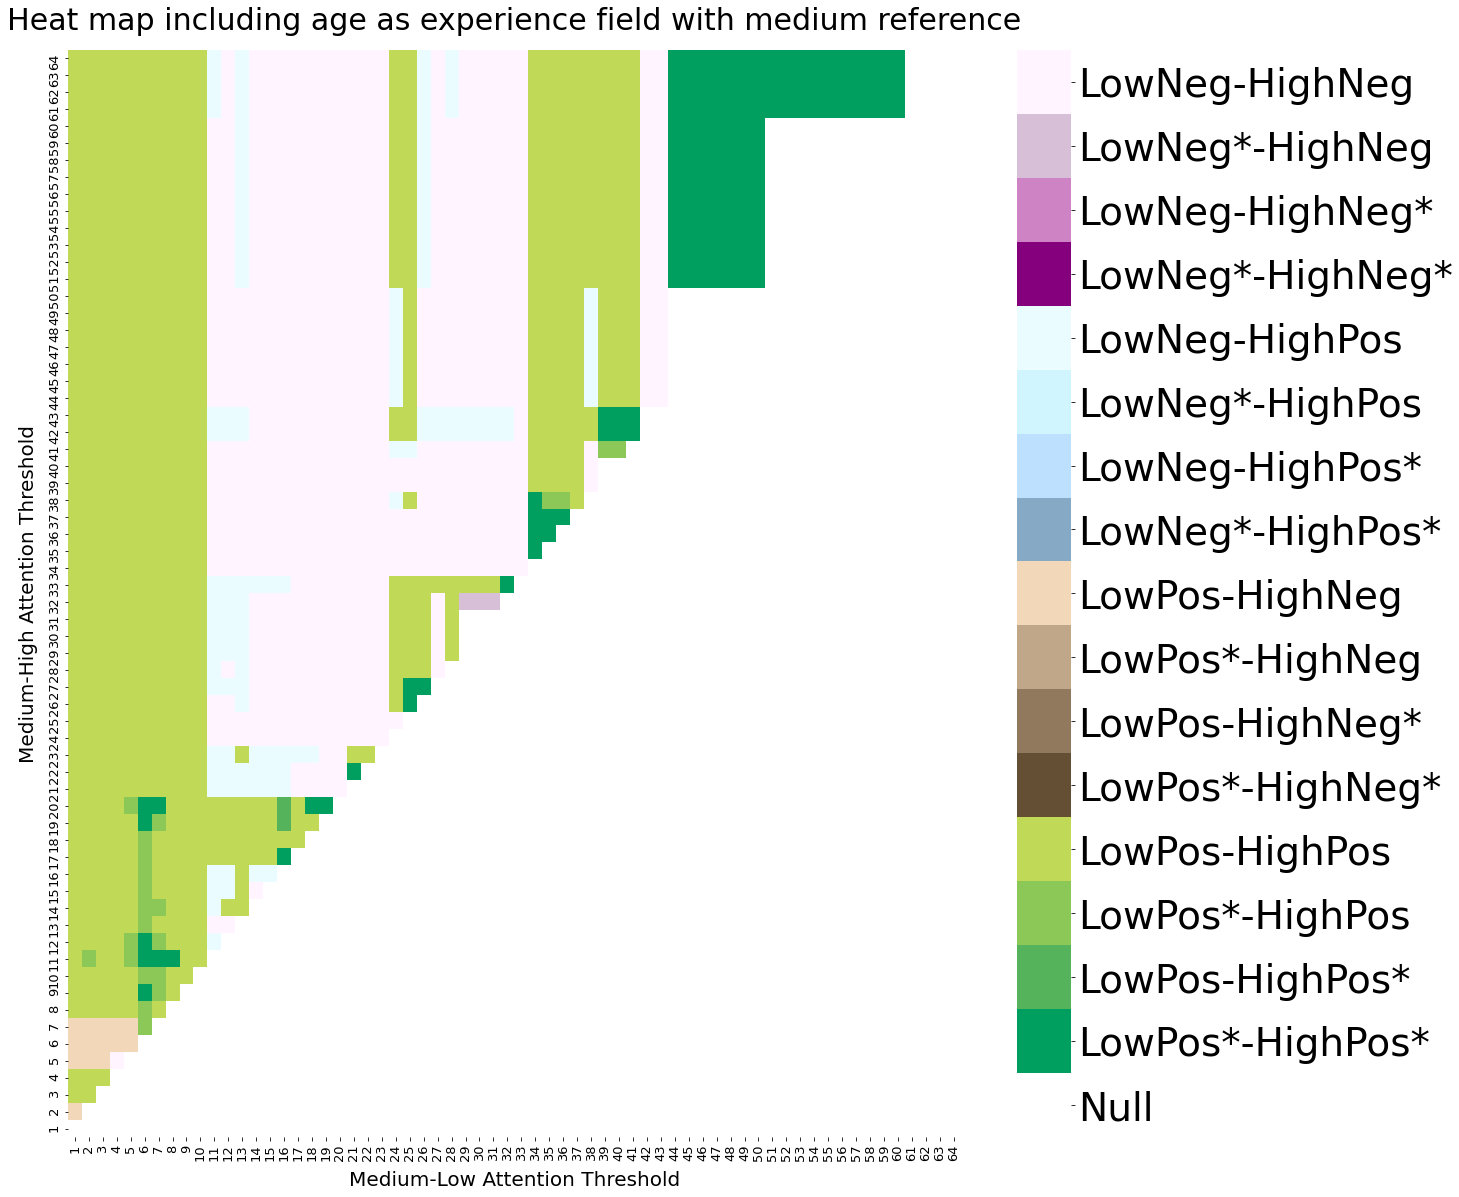

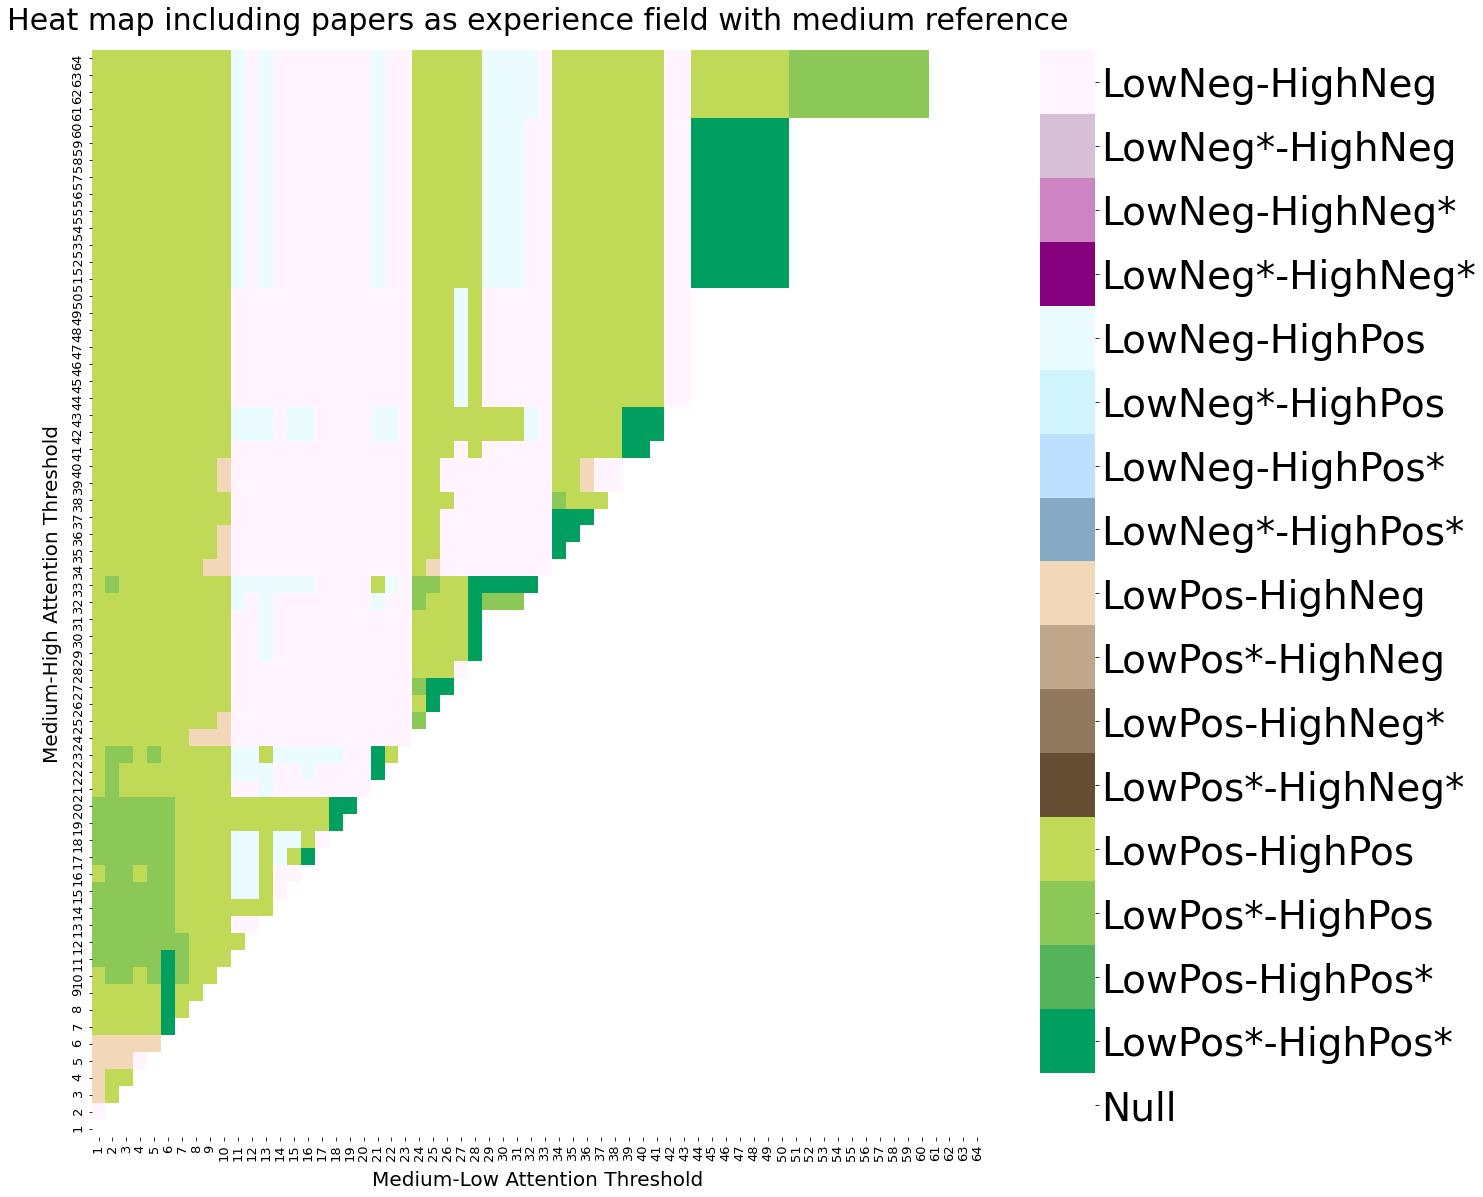

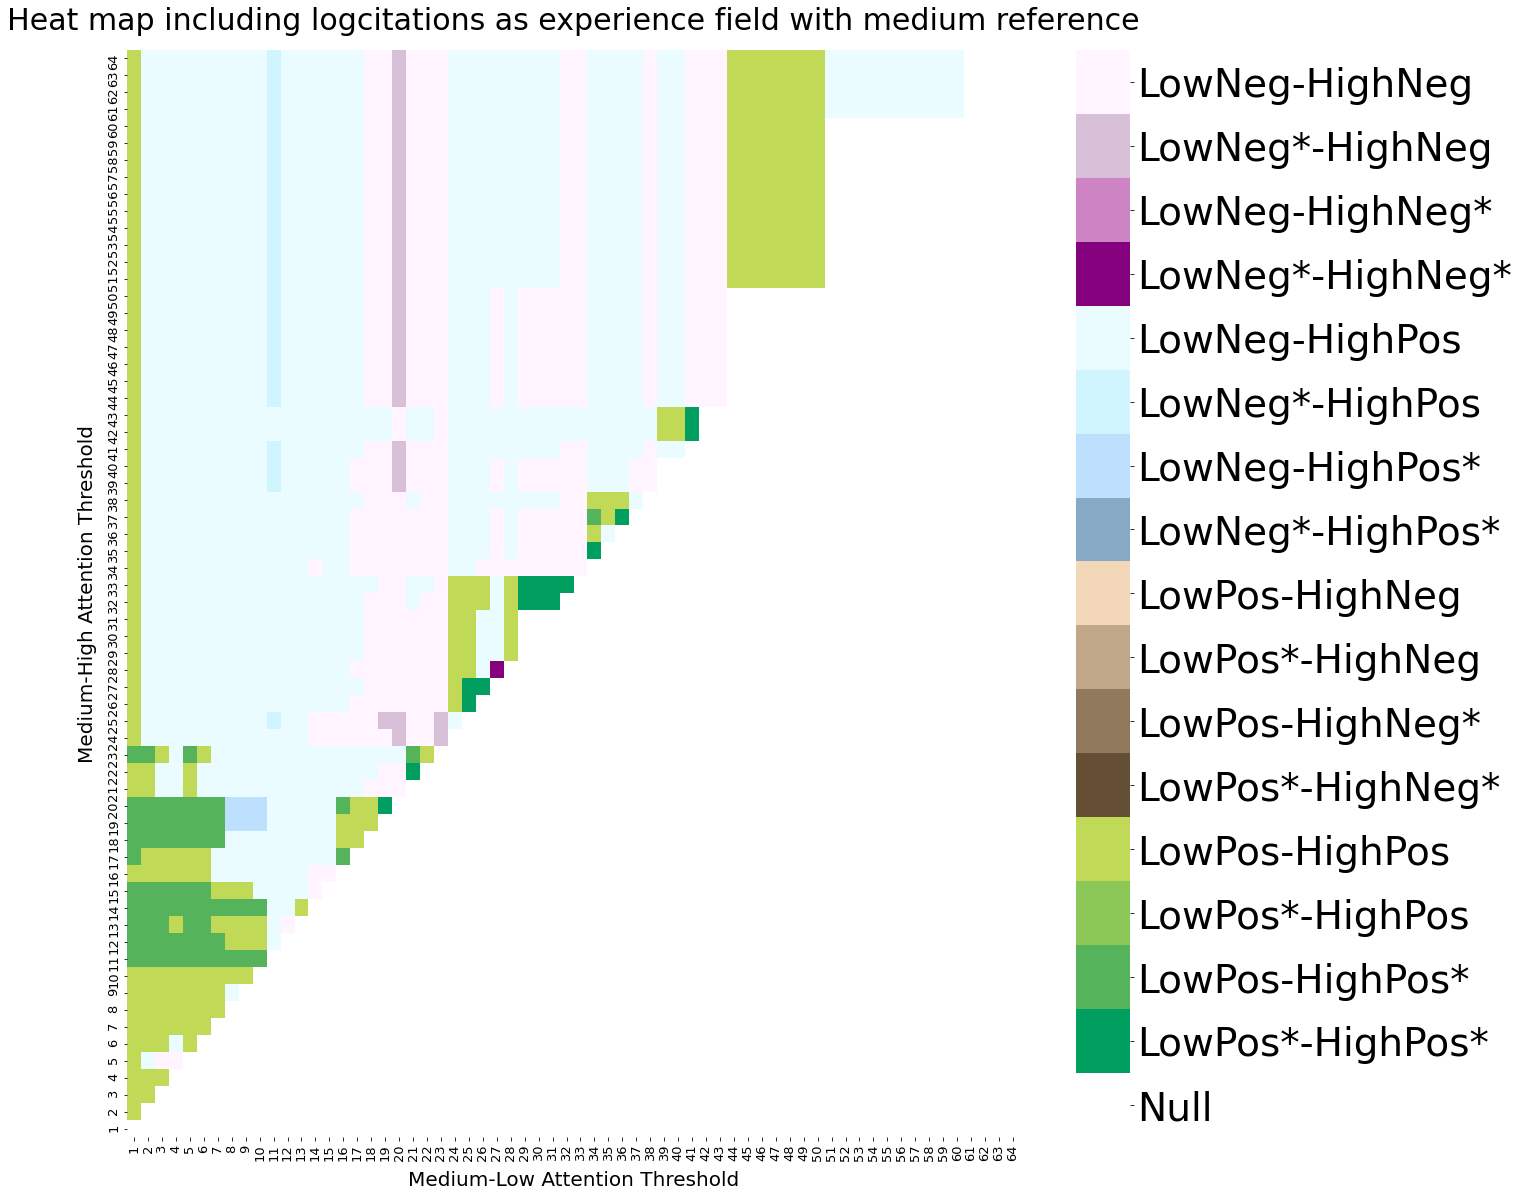

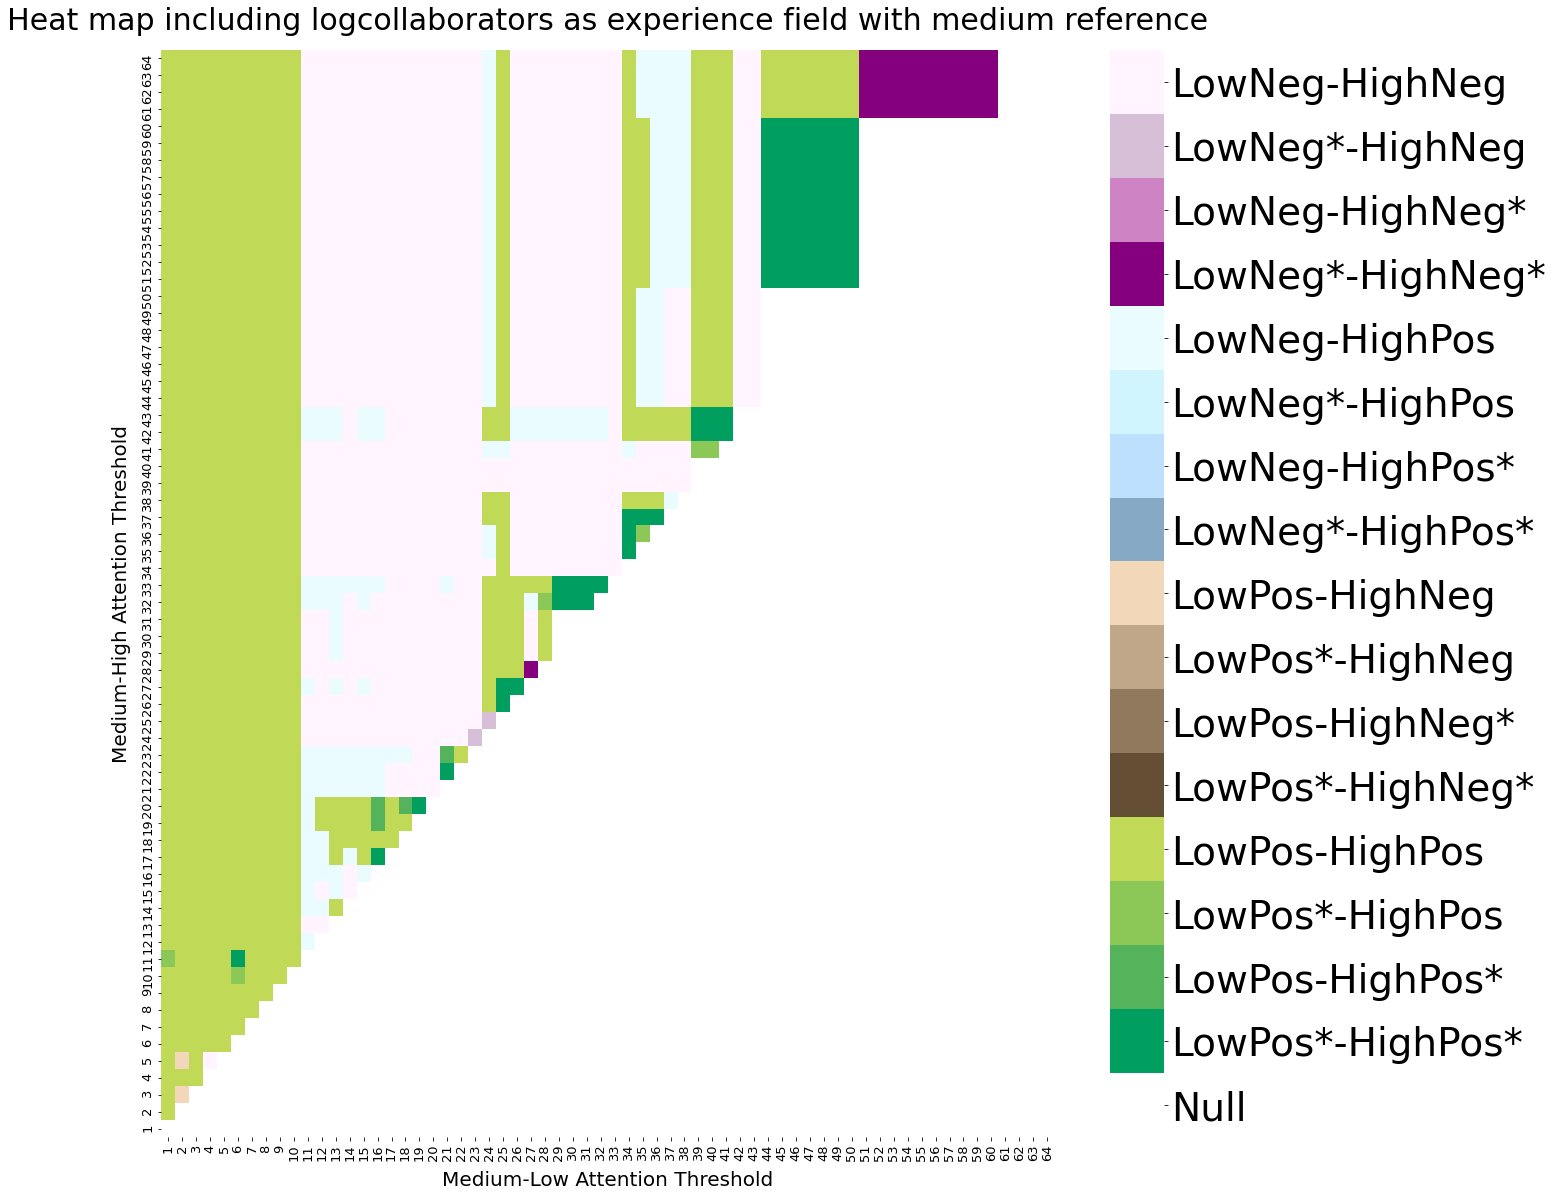

In [36]:
for experience_field in dict_tertiary_altmetric_mediumref.keys():
    
    title = "Heat map including " + experience_field + " as experience field with medium reference"
    
    threshold_dictionary = dict_tertiary_altmetric_mediumref.get(experience_field)
    
    df_threshold, cat_ord_color = prepare_data_2(threshold_dictionary,ub_altmetric)

    create_categorical_heatmap(df_threshold, tupLst_category_order_color=cat_ord_color, title=title,
                              tick_font_size=13)

In [20]:
# Importing relevant libraries

import pandas as pd
import math
from matplotlib.gridspec import GridSpec
import numpy as np

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# For colorbar
import matplotlib.colorbar as colorbar
import matplotlib.colors as clr

# For smoothing
from scipy.ndimage.filters import gaussian_filter

from collections import Counter

In [21]:
def prepare_data(threshold_dictionary, ub, reference_category='medium'):
    
    # This is the dictionary we prepare to create the dataframe for plot
    dict_for_df = {}
    
    # Going through each medium threshold
    for medium in range(1,ub):
        # Initializing the medium threshold list
        dict_for_df[medium] = []
        # Going through each high threshold
        for high in range(1,ub):
            # Let us get the value at this threshold
            paramsMediumOrLow,paramsHigh = threshold_dictionary.get((medium,high),(None,None))
            category = "Null" # This is category for when medium >= high
            
            if not pd.isnull(paramsMediumOrLow):
                # Expanding the tuples
                coefMediumOrLow, pvalMediumOrLow = paramsMediumOrLow
                coefHigh, pvalHigh = paramsHigh
                
                # Defining based on Coefficients
                mediumOrLowCategory = "LowPos" if coefMediumOrLow > 0 else "LowNeg"
                
                if reference_category=='low':
                    mediumOrLowCategory = "MedPos" if coefMediumOrLow > 0 else "MedNeg"
                
                highCategory = "HighPos" if coefHigh > 0 else "HighNeg"
                
                
                # Editing based on p-values
                mediumOrLowCategory = mediumOrLowCategory+"*" if pvalMediumOrLow <= 0.05 else mediumOrLowCategory
                highCategory = highCategory+"*" if pvalHigh <= 0.05 else highCategory
                
                
                category = mediumOrLowCategory + "-" + highCategory
                
                
            # Appending the category in order (order matters)
            dict_for_df[medium].append(category)
        
    cat_ord_color = [('Null',0,'#f5f5f5'),
                ('LowPos*-HighPos*',1,'#00472b'),('LowPos-HighPos*',2,'#54B35B'),
                ('LowPos*-HighPos',3,'#8BC858'),('LowPos-HighPos',4,'#C0DA58'),

                ('LowPos*-HighNeg*',5,'#644F35'),('LowPos-HighNeg*',6,'#91795E'),
                ('LowPos*-HighNeg',7,'#C1A78A'),('LowPos-HighNeg',8,'#F3D7B9'),

                ('LowNeg*-HighPos*',9,'#86A9C5'),('LowNeg-HighPos*',10,'#bde0fe'),
                ('LowNeg*-HighPos',11,'#D0F5FF'),('LowNeg-HighPos',12,'#EAFCFF'),

                ('LowNeg*-HighNeg*',13,'#85007D'),('LowNeg-HighNeg*',14,'#CE84C4'),
                ('LowNeg*-HighNeg',15,'#D8BFD8'),('LowNeg-HighNeg',16,'#FFF4FF')]
    
    return pd.DataFrame(dict_for_df, index=list(range(1,ub))), cat_ord_color

In [27]:
df_thresholds[0]

1               2               3               4   \
1             Null            Null            Null            Null   
2   LowPos-HighPos            Null            Null            Null   
3   LowPos-HighPos  LowPos-HighPos            Null            Null   
4   LowPos-HighPos  LowPos-HighPos  LowPos-HighPos            Null   
5   LowPos-HighPos  LowPos-HighPos  LowNeg-HighNeg  LowNeg-HighNeg   
..             ...             ...             ...             ...   
60  LowPos-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
61  LowPos-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
62  LowPos-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
63  LowPos-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
64            Null            Null            Null            Null   

                5               6               7               8   \
1             Null            Null            Null            Null   
2             Null            Null            Null            Null   
3             Null            Null            Null            Null   
4             Null            Null            Null            Null   
5             Null            Null            Null            Null   
..             ...             ...             ...             ...   
60  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
61  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
62  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
63  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos  LowNeg-HighPos   
64            Null            Null            Null            Null   

                9               10  ...              55               56  \
1             Null            Null  ...            Null             Null   
2             Null            Null  ...            Null             Null   
3             Null            Null  ...            Null             Null   
4             Null            Null  ...            Null             Null   
5             Null            Null  ...            Null             Null   
..             ...             ...  ...             ...              ...   
60  LowNeg-HighPos  LowNeg-HighPos  ...  LowPos-HighPos  LowNeg*-HighNeg   
61  LowNeg-HighPos  LowNeg-HighPos  ...  LowNeg-HighNeg   LowNeg-HighNeg   
62  LowNeg-HighPos  LowNeg-HighPos  ...  LowNeg-HighNeg   LowNeg-HighNeg   
63  LowNeg-HighPos  LowNeg-HighPos  ...  LowNeg-HighNeg   LowNeg-HighNeg   
64            Null            Null  ...            Null             Null   

                 57              58              59              60    61  \
1              Null            Null            Null            Null  Null   
2              Null            Null            Null            Null  Null   
3              Null            Null            Null            Null  Null   
4              Null            Null            Null            Null  Null   
5              Null            Null            Null            Null  Null   
..              ...             ...             ...             ...   ...   
60  LowNeg*-HighNeg            Null            Null            Null  Null   
61   LowNeg-HighNeg  LowNeg-HighNeg  LowNeg-HighNeg  LowNeg-HighNeg  Null   
62   LowNeg-HighNeg  LowNeg-HighNeg  LowNeg-HighNeg  LowNeg-HighNeg  Null   
63   LowNeg-HighNeg  LowNeg-HighNeg  LowNeg-HighNeg  LowNeg-HighNeg  Null   
64             Null            Null            Null            Null  Null   

      62    63    64  
1   Null  Null  Null  
2   Null  Null  Null  
3   Null  Null  Null  
4   Null  Null  Null  
5   Null  Null  Null  
..   ...   ...   ...  
60  Null  Null  Null  
61  Null  Null  Null  
62  Null  Null  Null  
63  Null  Null  Null  
64  Null  Null  Null  

[64 rows x 64 columns]

In [23]:
df_thresholds = []
ub_altmetric = 65

experience_fields = list(dict_tertiary_altmetric_mediumref.keys())

for i in range(len(experience_fields)):
    
    experience_field = experience_fields[i]
    
    threshold_dictionary = dict_tertiary_altmetric_mediumref.get(experience_field)
    
    df_threshold, cat_ord_color = prepare_data(threshold_dictionary,ub_altmetric)
    
    df_thresholds.append(df_threshold)


df_threshold_intersection_3 = df_thresholds[0].copy()
df_threshold_intersection_4 = df_thresholds[0].copy()
categories_in_plot_3 = set()
categories_in_plot_4 = set()

for i in range(1,df_thresholds[0].shape[0]+1): #iterate over rows
    for j in range(1,df_thresholds[0].shape[1]+1): #iterate over columns

        value1 = df_thresholds[0].at[i, j]
        value2 = df_thresholds[1].at[i, j]
        value3 = df_thresholds[2].at[i, j]
        value4 = df_thresholds[3].at[i, j]
        
        most_occuring_val, highest_count = Counter([value1,value2,value3,value4]).most_common(1)[0]
        
        all4same = True if highest_count == 4 else False
        atleast3same = True if highest_count >= 3 else False
        
        if all4same and "*" in most_occuring_val:
            df_threshold_intersection_4.at[i,j] = most_occuring_val
            categories_in_plot_4.add(most_occuring_val)
        else:
            df_threshold_intersection_4.at[i,j] = "Null"
            categories_in_plot_4.add("Null")
            
            
        if atleast3same and "*" in most_occuring_val:
            df_threshold_intersection_3.at[i,j] = most_occuring_val
            categories_in_plot_3.add(most_occuring_val)
        else:
            df_threshold_intersection_3.at[i,j] = "Null"
            categories_in_plot_3.add("Null")

In [24]:
def create_categorical_heatmap(df, axesi, cpfromsns=None, 
                               tupLst_category_order_color=[], tick_font_size=40, title="",
                               spacing_of_tick_labels=2,
                               showcbar=False):
    
    """
    This function will take in the data frame, a tuple list mapping 
    each category to an order (1,2,3..,) and to color, and a tick_font_size 
    which is self-expl.
    """
    
    # converting each value to an integer for the heatmap
    value_to_int = {i:j for (i,j,k) in tupLst_category_order_color}
    
    #value_to_int = {j:i for i,j in enumerate(pd.unique(df.values.ravel()))}
    
    cmap = [color for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]

    # Extracting keys in order
    categories = [cat for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]
    #print(categories)
    
    # Checking the number of unique values we have for the legend
    n = len(value_to_int)
    
    # discrete colormap (n samples from a given cmap)
    if(cpfromsns):
        cmap = sns.color_palette(cpfromsns, n)
    
    # creating the heatmap
    ax = sns.heatmap(df.replace(value_to_int), 
                     ax=axesi,linewidths=0,
                     cmap=cmap, vmin=0,
                     vmax=len(tupLst_category_order_color),
                     xticklabels=spacing_of_tick_labels,
                     yticklabels=spacing_of_tick_labels,
                     cbar=showcbar) 
    
    # Invertint y-axis for better readability
    axesi.invert_yaxis()

In [25]:
def label_subplots(axi, labeli, xi=-0.1, yi=1.03):
    
    # Labeling the figure so that they can be referred in the paper
    axi.text(xi, yi, labeli, transform=axi.transAxes, fontfamily='DejaVu Sans',
      fontsize=200, fontweight='extra bold')

In [44]:
# Setting up the plot surface
fig = plt.figure(figsize=(160, 90))
gs = GridSpec(nrows=9, ncols=16)
#sns.set(font_scale=8)

# Zeroeth axes for dot plot for retention for full matched sample
ax0 = fig.add_subplot(gs[:4, :4])


# First axes for dot plot for gain for full matched sample
ax1 = fig.add_subplot(gs[4:8, :4], sharex=ax0)

# Second axes for bar plot showing author activity for full matched sample (attrition plot)
ax2 = fig.add_subplot(gs[:4, 4:8], sharey=ax0)


# Fourth axes for dot plot for retention for non-attrited authors
ax3 = fig.add_subplot(gs[4:8, 4:8], sharex=ax2, sharey=ax1)

# Fifth axes for dot plot for gain for non-attrited authors
ax4 = fig.add_subplot(gs[:8, 8:])

ax5 = fig.add_subplot(gs[8:, :])

axesLst = [ax0,ax1,ax2,ax3]

for i in range(len(experience_fields)):
    
    axesi = axesLst[i]
    
    title = "Heat map including " + experience_field + " as experience field with medium reference"
    
    df_threshold = df_thresholds[i]

    create_categorical_heatmap(df_threshold, axesi, tupLst_category_order_color=cat_ord_color, title=title,
                              spacing_of_tick_labels = 5)

            
title = "Heat map of the intersection of atleast 3 experience fields for significant values of attention"

create_categorical_heatmap(df_threshold_intersection_4, ax4, title=title,
                            tupLst_category_order_color=cat_ord_color)

ax0.tick_params(labelbottom=False, labeltop=True, labelsize=80, bottom=False, labelrotation=0)
ax0.tick_params(labelbottom=False, bottom=False, labelrotation=0)
ax1.tick_params(labelbottom=False, bottom=False, labelsize=80, labelrotation=0)
ax2.tick_params(labelbottom=False, bottom=False, left=False, labeltop=True, labelleft=False, labelsize=80, labelrotation=0)
ax3.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False, labelsize=80, labelrotation=0)
ax4.tick_params(labelbottom=False, labeltop=True, bottom=False, labelsize=100, labelrotation=0)

fig.supylabel('Medium-High Threshold', fontsize=150, x=0.02, y=0.6)
fig.supxlabel('Low-Medium Threshold', fontsize=150, y=1.01)

# Now let us add the colorbar

format_dict = {
                0:['LowPos-HighPos','#C0DA58',r'$\beta_{low},\beta_{high}$'],
                1:['LowPos*-HighPos','#8BC858',r'$\beta_{low}^*,\beta_{high}$'],
                2:['LowPos-HighPos*','#54B35B',r'$\beta_{low},\beta_{high}^*$'],
                3:['LowPos*-HighPos*','#00472b',r'$\beta_{low}^*,\beta_{high}^*$'],
                4:['LowPos-HighNeg','#F3D7B9',r'$\beta_{low},-\beta_{high}$'],
                5:['LowPos*-HighNeg','#C1A78A',r'$\beta_{low}^*,-\beta_{high}$'],
                6:['LowPos-HighNeg*','#91795E',r'$\beta_{low},-\beta_{high}^*$'],
                7:['LowPos*-HighNeg*','#644F35',r'$\beta_{low}^*,-\beta_{high}^*$'],
                8:['LowNeg-HighPos','#EAFCFF',r'$-\beta_{low},\beta_{high}$'],
                9:['LowNeg*-HighPos','#D0F5FF',r'$-\beta_{low}^*,\beta_{high}$'],
                10:['LowNeg-HighPos*','#bde0fe',r'$-\beta_{low},\beta_{high}^*$'],
                11:['LowNeg*-HighPos*','#86A9C5',r'$-\beta_{low}^*,\beta_{high}^*$'],
                12:['LowNeg-HighNeg','#FFF4FF',r'$-\beta_{low},-\beta_{high}$'],
                13:['LowNeg*-HighNeg','#D8BFD8',r'$-\beta_{low}^*,-\beta_{high}$'],
                14:['LowNeg-HighNeg*','#CE84C4',r'$-\beta_{low},-\beta_{high}^*$'],
                15:['LowNeg*-HighNeg*','#85007D',r'$-\beta_{low}^*,-\beta_{high}^*$']
}

cb_colors = [color for (category,color,label) in format_dict.values()]
num_colors = len(cb_colors)
cmap_ = clr.ListedColormap(cb_colors)


cb = colorbar.ColorbarBase(ax5, orientation='horizontal',
                           cmap=cmap_, norm=plt.Normalize(-0.5, num_colors - 0.5))

cb.set_ticks(range(num_colors))

labels = [label for (category,color,label) in format_dict.values()]

cb.ax.set_xticklabels(labels, fontsize=80)

cb.outline.set_visible(False)


# Annotating figures
label_subplots(ax0, "a")
label_subplots(ax1, "c")
label_subplots(ax2, "b")
label_subplots(ax3, "d")
label_subplots(ax4, "e", xi=-0.07, yi=1.01)

ax5.annotate("Both low and high attention are in direct\n"\
             "    relationship with attrition w.r.t\n"\
             "               medium attention.",
            fontsize=100, xy=(0.09, 0.03), xycoords='figure fraction')

ax5.annotate("Low and high attention are respectively\n" 
             " in direct and inverse relationship with\n"
             "    attrition w.r.t medium attention",
            fontsize=100, xy=(0.32, 0.03), xycoords='figure fraction')

ax5.annotate("Low and high attention are respectively\n" 
             " in inverse and direct relationship with\n"
             "    attrition w.r.t medium attention",
            fontsize=100, xy=(0.55, 0.03), xycoords='figure fraction')

ax5.annotate("Both low and high attention are in inverse\n"\
             "    relationship with attrition w.r.t\n"\
             "               medium attention.",
            fontsize=100, xy=(0.76, 0.03), xycoords='figure fraction')

plt.tight_layout(pad=10)
#plt.savefig('heatmaps_ols_attrition_wSJR.svg',dpi=1200)
plt.savefig('heatmaps_ols_attrition_wSJR.pdf',format='pdf')
